# Introduction

In books and especially on the web, there are hundreds of indicators, however the vast majority are based on key mathematical concepts. These can be classified into types such as: oscillators, trend, volumetric, etc...

Some names in the industry are well known (RSI, MACD, BB, among others...), and those more complex ones created by mathematicians and/or programmers which have these principles, follow the trend and measure the strength of the market to study its behavior. However, what is behind these formulas?, what sustains them?, the recursive nature of the this makes them a separate subject to study and above all their practical behavior in the face of factors and the evolution of the process (stochastic in this case) such as outliers or spikes in volatility, up to some sigma event that breaks them and produces "false signals".

This research aims to uncover such effects, at least for the most classic indicators, which are as follows:
 * SMA
 * EMA
 * RSI

And a statistical analysis using probabilistic programming techniques, such as Monte Carlo simulation to study the effect of outliers on the formulas (all the code I designed for this will be presented later). There are other important indicators, for example the MACD, ATR, Bollinger bands and OBV. However the concepts learned here can be applied to any indicator regardless of type, and more importantly many of the above formulas are based on an SMA or EMA and the "strength" principles used by the RSI, which are delayed formulas.


Topics:
 * Analysis of SMA
 * SMA: Montecarlo and probabilistic programming to generate sequences of outliers in cumulative periods of time.
 * Reaction time and speed of the SMA without outliers.
 * Analysis: Exponential Moving Average(+SMA)
 * EMA: Montecarlo + prob. programming to generate sequences of outliers in cumulative periods of time.
 * Reaction time and speed of EMA without outliers
 * SMA vs EMA
 * R-Square of Person's coefficient without outliers
 * MAE - Mean absolute error.
 * RSI Analysis
 * Inflection point
 * RSI using Montecarlo and probabilistic programming
 * RSI reaction time and RSI speed without outliers.

# Load the necessary libraries to be used

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Analysis: Simple moving average

In the following we will analyze the SMA (simple moving averages), which are used (sometimes together with the EMAs) to determine trends and market conditions, studying the formula we will be able to understand its behavior and why it is not convenient in sideways markets. Later we will complement it with the EMA and the RSI since the latter makes use of this formula to obtain the "relative strength" of the market.

Definition:

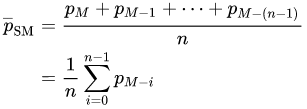

Let's analyze this formula in two parts

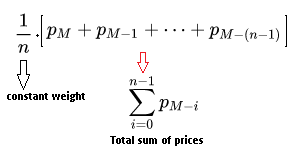

The **constant weight** (so named for this case) represents the weighting on the **total price aggregate**. This is because we know that multiplying a given value by a "weight" will penalize that value, resulting in a smaller one if it is bounded between (0, 1), and a larger one if it is between (1, +INF).

The great defect of this formula (and the reason why sometimes an exponential or weighted moving average is used) is its susceptibility to outliers, i.e. those values that according to a criterion exceed X times the average of the values to be weighted, we will now test this and how the perturbations affect the calculations.

# SMA: Monte Carlo and probabilistic programming to generate sequences of outliers in cumulative periods of time.

*In the following object of study we will make use of probabilistic programming and the monte-carlo method to generate a set of distributions that will simulate different intervals of percentage changes (this is how we will interpret it), also these values represent possible market conditions and/or market regimes, trends and laterals among others...*

We will create an algorithm that is able to iterate over a series of periods (representing the periods of the SMA), and for each time step we will sequentially inject outliers coming from a normal distribution of atypical volatility (large level of standard deviation), on the other hand the values that simulate the percentage price changes will also come from a normal distribution but with a much lower volatility. 
In addition we will calculate the value of the real mean (mean without bias or outliers) for each period of the formula and then we will display this information in a horizontal line that will serve as a basis for comparison with the mean biased by the increase in outliers, which we will call "True".

In this case the normal price distribution function will have a standard deviation of 0.5, while that of the atypical prices will be 5 standard deviations. Therefore 5/0.5=10 will be the number of times that the atypical value exceeds the normal value, this was chosen to represent extreme market conditions, although following the same logic this number can be taken to be 1.5(0.75/0.5) which is the conventional criterion used in box-plot diagrams.

In [ ]:
def MC_generate_pct_price_periods(periods, n_prices=1000, mean = 0, volatility = 0.5, volatility_outliers= 5.0):
  normal_dist = np.random.normal(mean, volatility, n_prices)
  outliers_dist = np.random.normal(mean, volatility_outliers, n_prices)
  means_ = []
  means_without_ols_ = []
  periods_ = []
  outliers_ = []
  for p in periods:
    for r in range(p):
      # the formula becomes unbalanced as the periods go by
      norm_choice = p - r
      outlier_choice= r
      prices = []
      # iterate over the n_prices
      for i in np.random.choice(normal_dist, norm_choice):
        prices.append(i)
      for i in np.random.choice(outliers_dist, outlier_choice):
        prices.append(i)

      m = np.mean(prices)

      # mean without outliers(the first mean will be the real or unbiased mean)
      if r == 0:
        means_without_ols_.append(m)
      else:
        # the above value will be the original value (from where you started, i.e. the actual average for each period p)
        means_without_ols_.append(means_without_ols_[-1])
        
      means_.append(m)
      periods_.append(p)
      outliers_.append(r)

  return pd.DataFrame(data={'Mean':means_, "Mean-without-outliers":means_without_ols_, 'Period':periods_, 'Outliers':outliers_})

periods = [3, 5, 8, 14, 30, 50, 80, 150, 200]
df_periods_info= MC_generate_pct_price_periods(periods)
df_periods_info.head()

,Mean,Mean-without-outliers,Period,Outliers
0,0.069068,0.069068,3,0
1,0.974884,0.069068,3,1
2,-1.020110,0.069068,3,2
3,-0.264212,-0.264212,5,0
4,-0.896863,-0.264212,5,1


Let's study four cases of typical SMA used in the market context, the periods will be: 14, 50, 80 and 200. Although there are variations of these periods we will take an approximation of the most used ones.

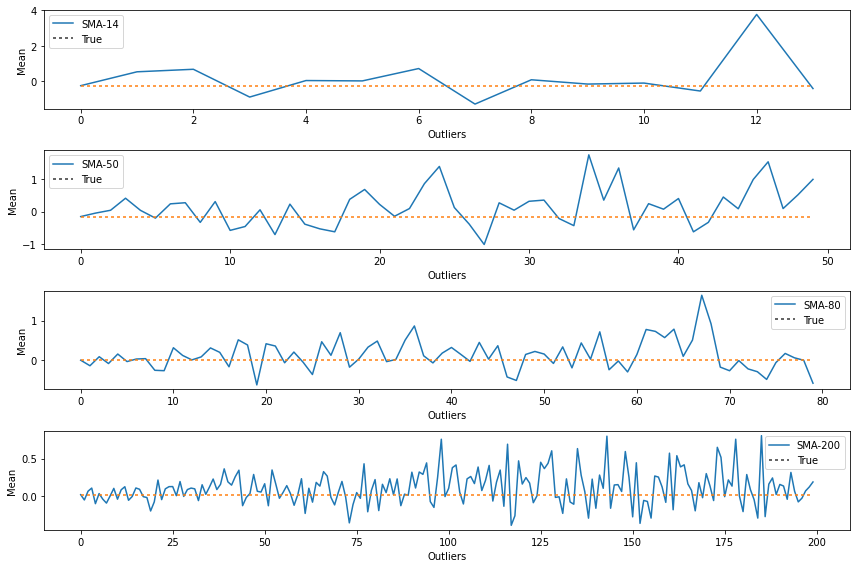

In [ ]:
def plot_means(df, periods, y_names, prefix):
  _, axs = plt.subplots(nrows=len(periods), figsize=(12, 8))
  i = 0
  for p in periods:
    df_p = df[df["Period"] == p]
    # mean with outliers
    sns.lineplot(data=df_p, x='Outliers', y=y_names[0], label=prefix+str(p), ax=axs[i])
    # mean-without-outliers
    sns.lineplot(data=df_p, x='Outliers', y=y_names[1], ax=axs[i], style=True, dashes=[(2,2)])
    i+= 1

plot_means(df=df_periods_info, periods=[14, 50, 80, 200], y_names=['Mean', 'Mean-without-outliers'], prefix='SMA-')
plt.tight_layout()
plt.show()

The graphs show the following: The X-axis represents the sequence of outliers that are added in order, i.e. we start from 0 outliers(all prices at that point are from a symmetric normal distribution with real mean 0), and as the iterations happen the outliers increase until reaching the N-1 period of the SMA. Thus the averages of each period represented by the Y-axis show the distortion caused by the outliers, the oscillation and the crosses with the horizontal axis(the true mean).

# Reaction time and speed of the SMA without outliers.

As we can see, having shorter periods of time, the SMA will move faster in the face of price changes, moving reasonably far away from the real average, while when we pass the 75 periods (approximately) we notice a clear reduction of the movement and as a consequence of this the average remains more and more stable.
At the end of the 200 periods the movement is absorbed and the mean resembles the real mean 0 (proposed at the beginning of the experiment).

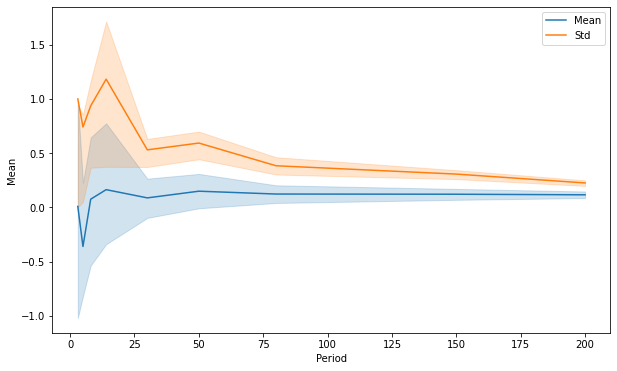

In [ ]:
plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_periods_info, x='Period', y='Mean', estimator='mean', label='Mean')
sns.lineplot(data=df_periods_info, x='Period', y='Mean', estimator='std', label="Std")
plt.show()



**Conclusion**

When we first start the simulation, the means are stable and quickly with time (the increase of outliers added to the formula) we observe how they suffer instability until at the end of each period the outliers (caused by extreme volatility) completely rule the formula, as a consequence the mean becomes larger.

This can be interpreted as follows, in periods of calm the market moves slowly, therefore the percentage price changes are minimal and if this remains so the average will remain at these values, but when large volume packages enter the volatility will appear quickly (leaving no possibility of reaction to the change to the SMA of larger periods such as 150). ... as a consequence we will have more erratic price movements and in short periods of time, when these are very large the SMA will be totally dominated by them (if the time persists), as a consequence if the volatility disappears immediately the smaller values will return and due to the simplicity of the formula will not be assimilated by it fast enough. We conclude by adding the following points

* In the SMA of shorter periods (such as the 14) the "reaction" to larger values is faster, however when outliers appear, even if they are few, the formula becomes unstable and quickly goes out of the average.

* In the SMA of longer periods (such as 150 or 200) the reaction to larger values is slower, when outliers appear the formula becomes unstable depending on the number of values that exist and in a longer time.

# Analysis: Exponential Moving Average(+SMA)

The previous study was fundamental to understand the following; the *exponential moving averages* have a similar use to the SMA and therefore the conclusion will not surprise us too much, nevertheless an analysis on the parts that form the formula is necessary to understand its behavior in the different time periods, we will also repeat the monte-carlo test to check this.

The formula is as follows:

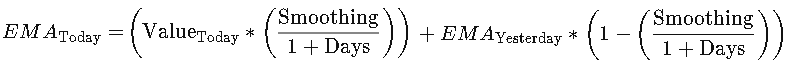

Each component is explained below:
  * Value_today: Current price value, i.e. where the market is at.
  * Smoothing: This is the smoothing factor (to be explained in a later section), the generally used value is 2.
  * Days: EMA period or length of days taken into account, the most used values will be studied later.
  * EMA_yesterday: The value of the EMA previous to the current one, this is so because the formula is recursive so that to know the current value, we need the immediate past (the calculation logic followed is exact for each instant of time).

In what follows we will focus on each aspect mentioned. Let's start with the "weight" of the formula:

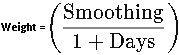

*Let us remember the following;* it is a division, therefore depending on the dominant value in the numerator or denominator the resulting "weight" or penalty that will be made on the current market price will be higher if it is a value less than 1 (and greater than 0) or lower if it is greater than 1.

The smoothing will be a constant value, therefore if the number of days or periods of the EMA exceeds this value it becomes obvious that the division will result in a value bounded between (0, 1], i.e. it will never be 0 nor greater than 1.
I will represent this as follows:
  * Days >= Smoothing : 0 < Weight <= 1

*Of course in the real world the chosen periods can never be smaller than the smoothing constant so the weight must necessarily be less than 1 and greater than 0.*

Let's see this with python, we will generate a list of smoothing factors, days or periods and resulting weights.

In [ ]:
def generate_weights_periods(n_smoothings_factors, n_days_factors):
  # we generate X possible smoothing factors
  smoothings_factors = [x + 1 for x in range(n_smoothings_factors)]
  # we generate X possible factors of days(or periods) for the EMA
  days_factors = [x for x in range(n_days_factors)]

  w_ = []
  s_ = []
  d_ = []
  for s in smoothings_factors:
    for d in days_factors:
      weight = s / (1 + d)
      w_.append(weight)
      s_.append(s)
      d_.append(d)

  return pd.DataFrame(data={'Weight':w_, "Smoothing":s_, 'Periods':d_})

df_weights_periods = generate_weights_periods(10, 50)
df_weights_periods

,Weight,Smoothing,Periods
0,1.000000,1,0
1,0.500000,1,1
2,0.333333,1,2
3,0.250000,1,3
4,0.200000,1,4
...,...,...,...
495,0.217391,10,45
496,0.212766,10,46
497,0.208333,10,47
498,0.204082,10,48


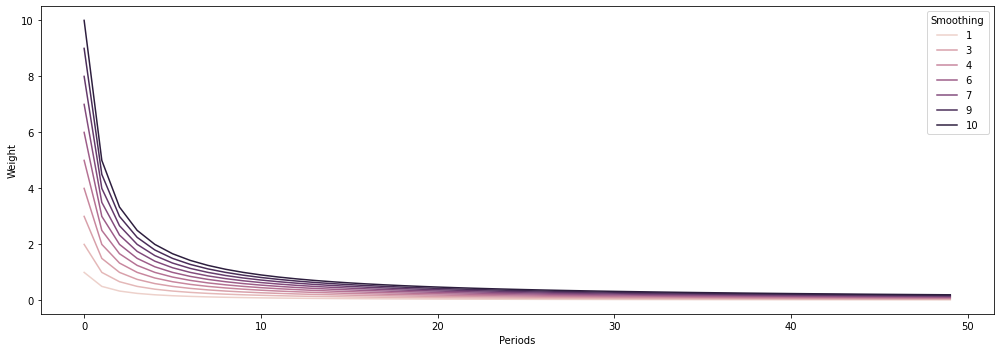

In [ ]:
_, axs = plt.subplots(figsize=(14,5))
sns.lineplot(data=df_weights_periods, x='Periods', y='Weight', hue='Smoothing')
plt.tight_layout()
plt.show()

The graph shows a set of decreasing exponential functions, what does this mean?; when the periods of the EMA increase sufficiently they far exceed the constant smoothing factor (the denominator of the formula becomes very large), so that the resulting values become closer and closer to an asymptote, i.e. tends to 0, and as we well know any value multiplied by something so small results in another even smaller value.

*This is what is formally known as weight or penalty as it punishes or rewards the current price values depending on how large they are.*

The next part of the formula is:

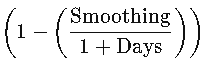

We are not going to spend much more time with this, the logic is the same but with a small change, remember that the total weight will always result in a value *less than 1*, so by subtracting 1 we will obtain the complementary.
If we plot this formula in the same way as we did with the previous one the exponential will be increasing, this makes sense because as one gains importance the other loses it.

*With respect to the EMA_yesterday value there is nothing more to add, it represents the calculation of the previous EMA. When the formula is calculated for the first time we will not have this value, so it can be initialized to 0 or any other number of your choice. Sometimes an SMA is used to weight X periods in the past and get this initial value so that we will have a base with which to start our subsequent calculations.*


# EMA: Monte Carlo + probabilistic programming to generate sequences of outliers in cumulative periods of time.

Repeating the formula of the first section studied (SMA), we will test how resistant the EMA is to the presence of outliers. The algorithm used is the same as the one we designed previously but with a small modification; the EMA formula.

In [ ]:
def MC_generate_EMA_pct_price_periods(periods, n_prices=1000, mean = 0, volatility = 0.5, volatility_outliers= 5.0):
  normal_dist = np.random.normal(mean, volatility, n_prices)
  outliers_dist = np.random.normal(mean, volatility_outliers, n_prices)
  emas_ = []
  emas_without_ols_ = []
  periods_ = []
  outliers_ = []
  for p in periods:

    for r in range(p):
      norm_choice = p - r
      outlier_choice= r
      prices = []
      for i in np.random.choice(normal_dist, norm_choice):
        prices.append(i)
      for i in np.random.choice(outliers_dist, outlier_choice):
        prices.append(i)

      # we calculate the EMA and take the last value which is the value for the period
      ema = pd.DataFrame(data={'p':prices})['p'].ewm(span=p, adjust=False).mean()[p-1]

      # without outliers(the first calculation will be the actual or unbiased one) with the original period P
      if r == 0:
        emas_without_ols_.append(ema)
      else:
        # the previous value will be the original value (i.e. from where you started)
        emas_without_ols_.append(emas_without_ols_[-1])

      emas_.append(ema)
      periods_.append(p)
      outliers_.append(r)

  return pd.DataFrame(data={'Mean':emas_, "Mean-without-outliers":emas_without_ols_, 'Period':periods_, 'Outliers':outliers_})

periods = [5, 14, 30, 50, 80, 200]
df_periods_info= MC_generate_EMA_pct_price_periods(periods)
df_periods_info.head()

,Mean,Mean-without-outliers,Period,Outliers
0,0.169639,0.169639,5,0
1,0.474915,0.169639,5,1
2,0.820846,0.169639,5,2
3,0.558945,0.169639,5,3
4,-0.090929,0.169639,5,4


Let's study four cases of the most used EMAs in the market context, the periods will be: 5, 14, 30, 80 and 200. Although there are variations of these periods we took an approximate of the most used ones

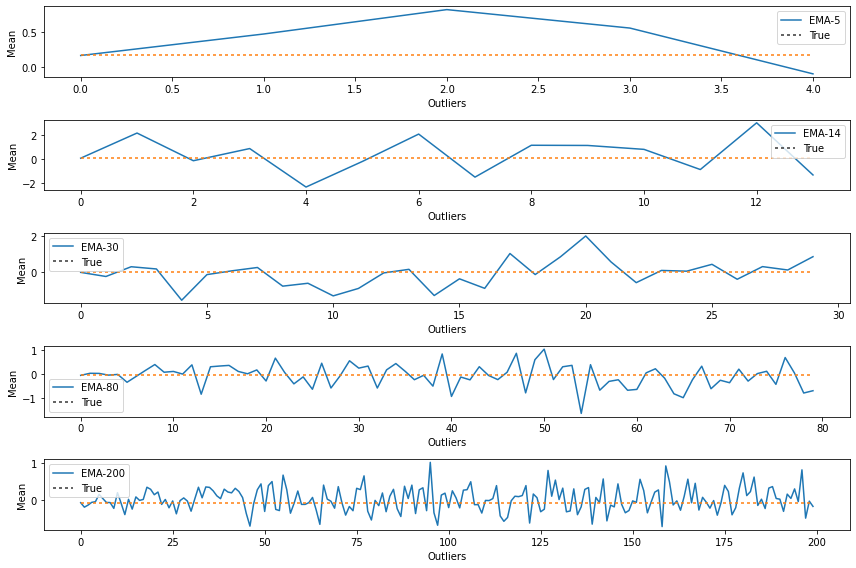

In [ ]:
plot_means(df=df_periods_info, periods=[5, 14, 30, 80, 200], y_names=['Mean', 'Mean-without-outliers'], prefix='EMA-')
plt.tight_layout()
plt.show()

The graphical analysis and its conclusion is the same as in the SMA section, as already mentioned, the oscillation of values with respect to the real mean 0 (the horizontal line) is produced by the presence of outliers. As the periods of the EMAs get longer, they lose their reaction to price changes. The difference here is in the word "exponential" which means that the prices assigned to the formula will lose and gain weight in an **exponential** manner. As already mentioned this is what is commonly referred to as "paying attention to the most recent prices".

Remark: *The difference of oscillations versus the SMA is miniscule, only visible in the shorter periods, while in the longer ones they behave similarly... next we will continue with the analysis of speed and reaction we have been seeing.*

# Reaction time and speed of EMA without outliers

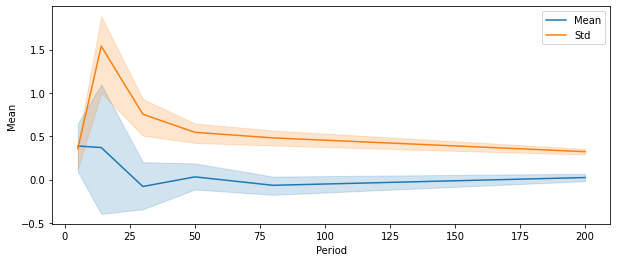

In [ ]:
plt.subplots(figsize=(10, 4))
sns.lineplot(data=df_periods_info, x='Period', y='Mean', estimator='mean', label="Mean")
sns.lineplot(data=df_periods_info, x='Period', y='Mean', estimator='std', label="Std")
plt.show()

If we compare the same analysis done in the SMA section we will not see much difference in speed and reaction, however this section and the previous one stand out visually. It is now when we need an analytical method able to give us some ratio of how true this is and when this change occurs. All this in the next section!

* The longer the periods of the EMAs and SMAs are, they will tend to the same behavior (their differences disappear and become similar), if for example we have an EMA and SMA of 200 periods in length their curves will be very similar and therefore they will be close to each other, this characteristic does not depend on the volatility of the values.
* In short periods of time the SMA and EMA have more pronounced differences, this is so because the EMA gives small weights to the most recent values so that when they are very large they will be punished to a greater extent and thus gaining better stability in the results.

*Therefore it is a very good decision to use it in short periods for the most volatile markets if our strategy is based on stability.*

# SMA vs EMA

So far it was interesting to evaluate the different types of means separately and study their characteristics, however in our present experiment we will look for similarities and contrasts in their formulas. Let us begin by reformulating the monte-carlo method used so far, then prepare it so that it is able to generate the same data for both types of means.

In [ ]:
def MC_generate_MA_pct_price_periods(periods, n_prices=1000, mean = 0, volatility = 0.5, volatility_outliers= 5.0):
  normal_dist = np.random.normal(mean, volatility, n_prices)
  outliers_dist = np.random.normal(mean, volatility_outliers, n_prices)
  emas_ = []
  smas_ = []
  smas_without_ols_ = []
  emas_without_ols_ = []
  periods_ = []
  outliers_ = []
  for p in periods:
    # Inject outliers over time
    for r in range(p):
      norm_choice = p - r
      outlier_choice= r
      prices = []
      for i in np.random.choice(normal_dist, norm_choice):
        prices.append(i)
      for i in np.random.choice(outliers_dist, outlier_choice):
        prices.append(i)

      ema = pd.DataFrame(data={'p':prices})['p'].ewm(span=p, adjust=False).mean()[p-1]
      sma = np.mean(prices)

      if r == 0:
        emas_without_ols_.append(ema)
        smas_without_ols_.append(sma)
      else:
        emas_without_ols_.append(emas_without_ols_[-1])
        smas_without_ols_.append(smas_without_ols_[-1])

      emas_.append(ema)
      smas_.append(sma)
      periods_.append(p)
      outliers_.append(r)

  return pd.DataFrame(data={
      'SMA':smas_, 'EMA':emas_,
      "SMA-without-outliers":smas_without_ols_, "EMA-without-outliers":emas_without_ols_,
      'Period':periods_,
      'Outliers':outliers_})

In [ ]:
periods = [5, 14, 30, 50, 80, 200]
df_MA_periods_info= MC_generate_MA_pct_price_periods(periods)

Let's overlap the outliers influence graphs, we want to see how much they diverge.

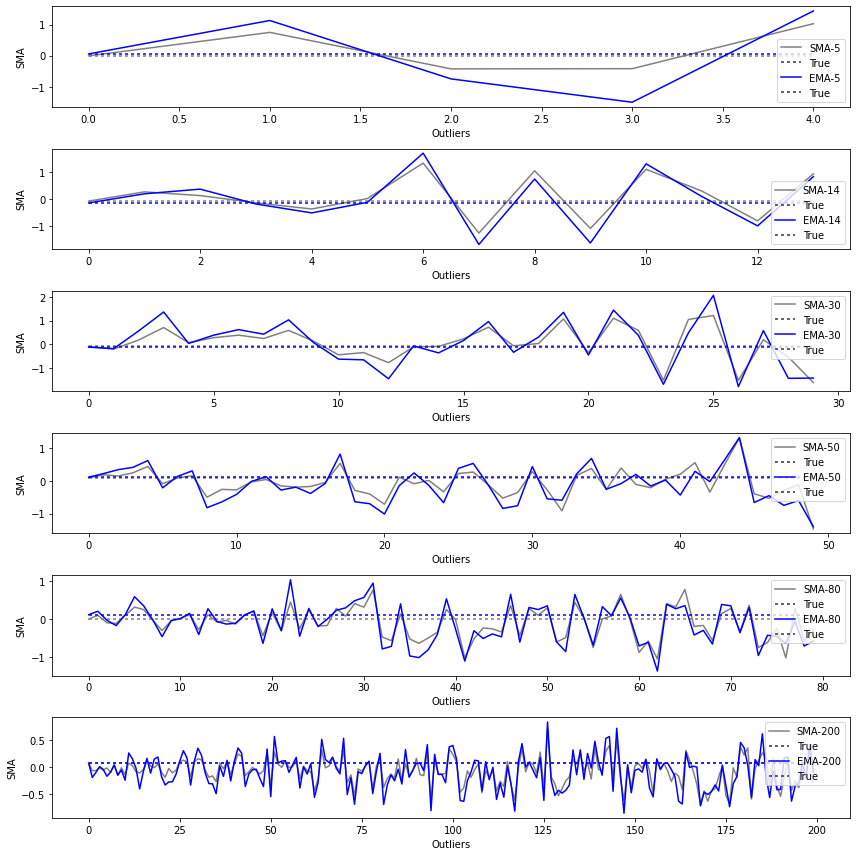

In [ ]:
def plot_multiple_means(df, periods, colors):
  _, axs = plt.subplots(nrows=len(periods), figsize=(12, 12))
  i = 0
  prefix = ['SMA-', 'EMA-']
  y_names= ['SMA', 'EMA']
  y_ols  = ['SMA-without-outliers', 'EMA-without-outliers']
  for p in periods:
    for d in zip(y_names, y_ols, prefix, colors):
      y_1   = d[0]
      y_2   = d[1]
      lbl   = d[2] + str(p)
      col   = d[3]
      df_p  = df[df["Period"] == p]
      sns.lineplot(data=df_p, x='Outliers', y=y_1, label=lbl, ax=axs[i], color=col, err_style=None, estimator="mean")
      sns.lineplot(data=df_p, x='Outliers', y=y_2, ax=axs[i], color=col, err_style=None, style=True, dashes=[(2,2)], estimator="mean")
    i+= 1

plot_multiple_means(df_MA_periods_info, periods, ['gray', 'blue'])
plt.tight_layout()
plt.show()

Clearly the divergence of the MAs in the presence of outliers disappears as the periods become larger, when reaching 200 the differences are insignificant, let's continue with this analysis using an analytical method.

# R-square or Person's coefficient, without outliers

The first test we will do will be to check the similarity of both moving averages when there are no outliers, for this we will repeat the experiment from the beginning adding more periods to make a more detailed analysis, although the absence of outliers is an ideal situation, we will start from here to evaluate if there is any radical difference. For this we will use the *Pearson's coefficient* which calculates the amount of linear relationship that exists in the values, in other words, how closely the values move together.

* This coefficient ranges between [-1, 1], being 1 the perfect correlation (the prices move exactly the same, there is no difference between them). If the value is close to (or equal to) 0 then the values show no relationship of joint movement, if it is -1 then they move perfectly equally but in opposite directions. From this we deduce the following: By having a correlation *less than or equal* to 0.5 we are in the presence of little or weak relationship of the studied values.
* The following graph will show a heatmap (using the correlation matrix), and two lineplots. The first one will show on the X axis the different periods of the EMAs studied and on the Y axis their value (i.e. the price), the second one will show the same on the X and Y axis but instead they will be the SMAs.

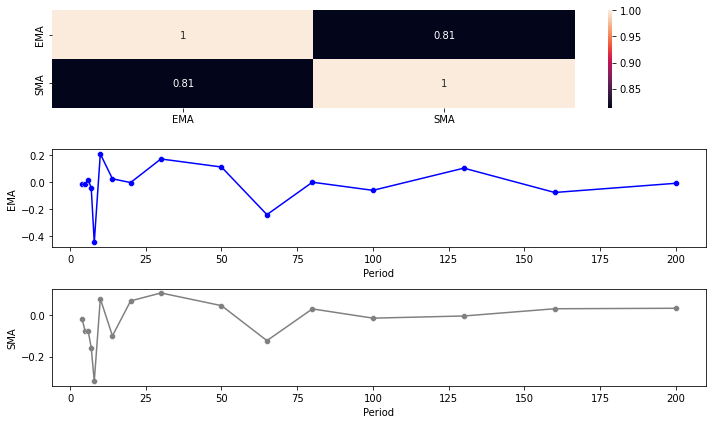

In [ ]:
extra_periods = [4, 5, 6, 7, 8, 10, 14, 20, 30, 50, 65, 80, 100, 130, 160, 200]
df_MA_periods_info= MC_generate_MA_pct_price_periods(extra_periods)

_, axs = plt.subplots(figsize=(10, 6), nrows=3)
ma_without_outliers = df_MA_periods_info[df_MA_periods_info['Outliers']==0][['EMA', 'SMA', 'Period']]
sns.heatmap(ma_without_outliers[['EMA', 'SMA']].corr(), annot=True, ax=axs[0])
sns.lineplot(data=ma_without_outliers, x='Period', y='EMA', ax=axs[1], color='blue')
sns.scatterplot(data=ma_without_outliers, x='Period', y='EMA', ax=axs[1], color='blue')
sns.lineplot(data=ma_without_outliers, x='Period', y='SMA', ax=axs[2], color='gray')
sns.scatterplot(data=ma_without_outliers, x='Period', y='SMA', ax=axs[2], color='gray')
plt.tight_layout()
plt.show()

The correlation coefficient shows a good linear relationship between the EMA and SMA (remember that the values of the coefficient may vary due to the implicit stochasticity of the experiment), with which we infer that when there are no outliers the MAs move in a similar way.

# MAE - Mean absolute error

Now things get more complicated, we no longer have a single possibility of outliers, on the contrary, these will increase as the period of the moving averages increases and therefore we will need a more flexible method that is able to accurately capture the similarities of the averages in successive periods, for this we will rely on the concept of error. Although this word may suggest that something is wrong, it is not. In the area of machine learning and deep learning a concept often used is that of the *error function*, which expresses a difference or distance between two data sets, or in other words how close one value is to another (precisely this is the notion of distance).

Therefore we say for this case study that the smaller the error the greater the similarity between the moving averages. Let's take a look at the formula:

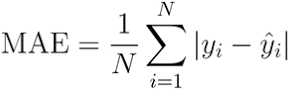

In [ ]:
from sklearn.metrics import mean_absolute_error

def compute_MAs_error(df, periods, pct_outliers):
  periods_ = []
  maes_= []
  ols_pct_ = []
  ols_n_ = []
  for p in extra_periods:
    for ols in pct_outliers:
      n = int(np.round(p * ols))
      if n == 0:
        continue

      df_ = df[df['Outliers']==n]
      if df_.shape[0] == 0:
        continue
      maes_.append(np.round(mean_absolute_error(df_["SMA"].values, df_["EMA"].values)*100, 2))
      periods_.append(p)
      ols_pct_.append(ols*100)
      ols_n_.append(n)

  return pd.DataFrame(data={'MAE':maes_, 'Period':periods_, 'Outliers_%':ols_pct_, 'Outliers_n':ols_n_})

By calculating the error using percentages of outliers (for each different period of averages) we will not need to rely on a fixed number, which is not adequate when the time periods are different. For example, it is not the same 5 outliers in a 14-period moving average than in a 200-period moving average.

Next we will calculate the MAE between each moving average over the periods, along with the percentage and number of outliers influencing each of them.

In [ ]:
pct_outliers = [.1, .2, .4, .5]
MAS_error = compute_MAs_error(df_MA_periods_info, extra_periods, pct_outliers)
MAS_error.head()

,MAE,Period,Outliers_%,Outliers_n
0,22.07,4,20.0,1
1,20.18,4,40.0,2
2,20.18,4,50.0,2
3,22.07,5,20.0,1
4,20.18,5,40.0,2


The following graph will show the following:
  * On the X axis we have the MAE, which represents the percentage difference between the moving averages (the SMA and the EMA). The smaller the MAE, the more similar they will be.
  * On the Y-axis we have the Periods of the moving averages which are getting larger and larger.
  * The hue shows a text box with the percentages of Outliers influencing each set or group of moving averages. Recall that each color curve represents how much difference there is between the means due to the precession of atypical data.

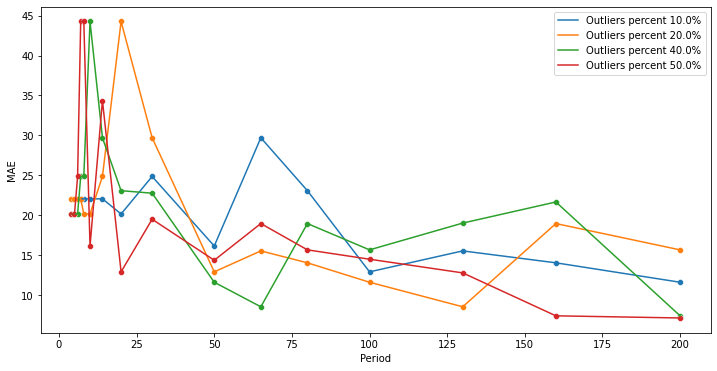

In [ ]:
plt.subplots(figsize=(12, 6))
for pct in pct_outliers:
  pct_ = pct*100
  df_ = MAS_error[MAS_error['Outliers_%']==pct_]
  sns.lineplot(data=df_, x='Period', y='MAE', err_style=None, label='Outliers percent '+str(pct_)+'%')
  sns.scatterplot(data=df_, x='Period', y='MAE')
plt.show()

**Conclusion**

The result was what we expected, in the first periods of the averages (let's say smaller than 20) we see how the different outliers influence abruptly in the percentage of error, the MAE is in an approximate of say 30% which means that in the presence of different outliers the EMA and SMA react 30% different, as the periods become larger and the outliers increase or decrease these differences decay sufficiently, i.e. at least we see a decrease of this ratio (the MAE) with which their type of reaction is more similar. Until reaching 200 such differences are no longer relevant.

# RSI Analysis

Having understood the SMA formula it is time to study the RSI or *relative strength index*, first let's review the formula.

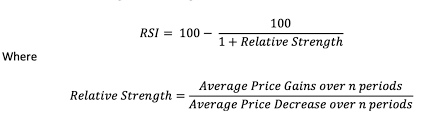

The first term to understand is the RS or "relative strength", which is found in the denominator of the formula and represents the average percentage of wins over percentage of losses in a given period.

For this task we will generate two lines intersecting at a point, which simulate the percentages mentioned above. In the markets as in any stochastic phenomenon there is no linearity and therefore the following graph should not be interpreted as such, this is a representation of incremental percentages, therefore for study purposes it is correct to observe the change in the ratio of averages as they approach and move away from a given point.

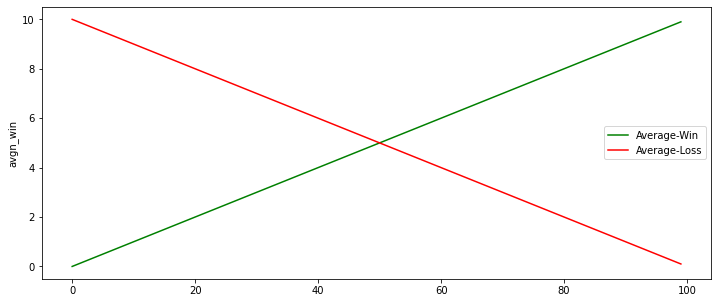

In [ ]:
# funcion de paso para crear la secuencia lineal
def generate_step_serie(start, size, step=1):
  v = []
  x = start
  for _ in range(size):
    v.append(x)
    x+= step
  return v

# total de observaciones de la serie
size = 100
# incremento de paso de la funcion
step = 0.1
aw = generate_step_serie(0, size, +step)
al = generate_step_serie(10,size, -step)
RSI = pd.DataFrame(data={"avgn_win":aw, "avgn_loss":al})

plt.subplots(figsize=(12,5))
sns.lineplot(data=RSI["avgn_win"] , label="Average-Win" , color='g')
sns.lineplot(data=RSI["avgn_loss"], label="Average-Loss", color='r')
plt.show()

The change and crossing of the rate averages will show an exponential. This is logical to deduce (though perhaps not intuitive) because of the formula.

* **When the percentage of wins** is greater than the percentage of losses, the resulting value will be: RS:[1, +inf).
* **When the percentage of losses** exceeds the percentage of wins, the resulting value will be RS:[0, 1).

Because of this, when the gains are below the losses, the values will accumulate closer and closer to 0. And conversely, when the gains exceed the losses, they will tend more quickly to values greater than 1.
Therefore, what we see in the final values of the following graph is the product of the crossing of the percentage lines plotted in the previous step, the *Average-Win* intersecting the *Average-Loss*.

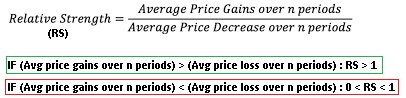

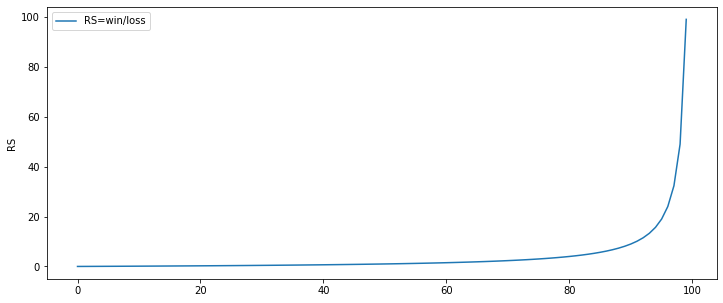

In [ ]:
RSI["RS"] = (RSI["avgn_win"]/RSI["avgn_loss"])

plt.subplots(figsize=(12,5))
sns.lineplot(data=RSI["RS"], label="RS=win/loss")
plt.show()

# Inflection point

Let's check the above in a simpler way, we will create a conditional function that determines the exact crossing point (i.e. the inflection point), we will also show a graph which shows the dominant average.

* If: RS >= 1, RS = 1
* Otherwise: RS < 1, RS = 0

Inflection point:(51, 1.040816326530608)


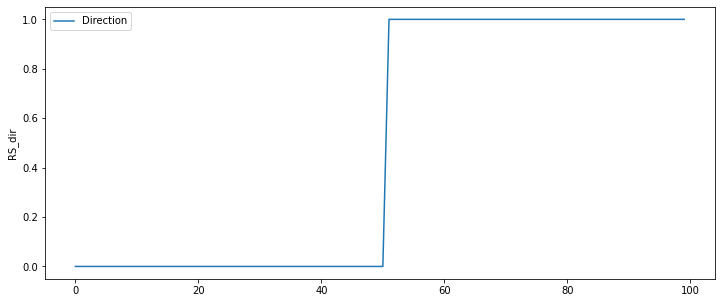

In [ ]:
def calculate_inflection_point(data):
  thr = []
  inf_point = None
  l = len(data)
  for i in range(l):
    if (inf_point is None) and (i > 0):
      if (data[i] >= 1.0 and data[i-1] < 1) or (data[i] < 1 and data[i-1] >= 1):
        inf_point = (i, data[i])

    if data[i] >= 1.0:
      thr.append(1)
    else:
      thr.append(0)
  
  return thr, inf_point

thr, inf_point = calculate_inflection_point(RSI["RS"])
RSI["RS_dir"] = thr
print("Inflection point:{}".format(inf_point))

plt.subplots(figsize=(12,5))
sns.lineplot(data=RSI["RS_dir"], label="Direction")
plt.show()

That is to say, after the 50th position of our average array is when the first gain over loss occurs with a ratio of 1.040...

The following is to observe the behavior of the fraction including the RS calculations. The following should be noted:
* *When the denominator is very large, the average percentage gains totally dominate the losses. The result of a division over a giant value is very close to 0*.
* *When the denominator is very small, the average percentage of losses dominates over wins. The result of a division over an extremely small value tends to infinity, HOWEVER it is here that we must take into account the +1 in the formula, which will not allow the excess mentioned above.*


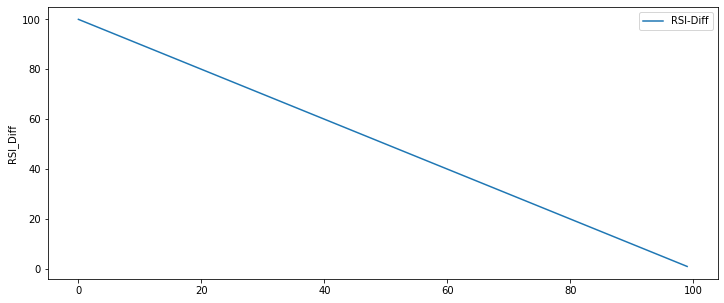

In [ ]:
RSI["RSI_Diff"] = 100 / (1 + RSI["RS"])
plt.subplots(figsize=(12,5))
sns.lineplot(data=RSI["RSI_Diff"], label="RSI-Diff")
plt.show()

```
The linear "drop" we see is the difference of the RSI going from oversold to 
overbought, or in other words the final value of the average gain over loss.

Repeating the last concept we have that when the denominator value is very 
close to 0 the ratio will be approximately 100(100/(1 + ~0)), resulting in an 
oversell(depending on where we place our threshold in the indicator, generally
30) since in the end 100 - ~100 = ~0. Otherwise the ratio will be close to 0 
(since the denominator will tend to 100 or greater and 100 - (100/(1+>~100)) = ~100) 
resulting in an overbought (again depending on where we place our threshold, generally 70).
```

Finally:

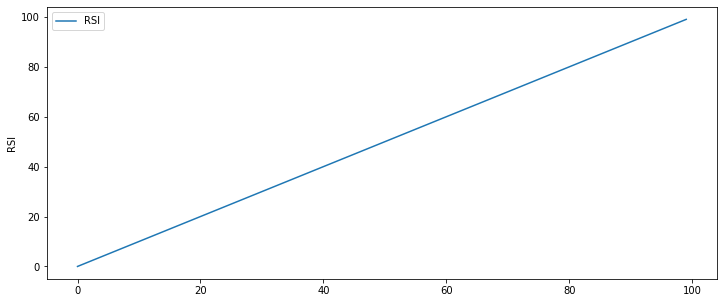

In [ ]:
plt.subplots(figsize=(12,5))
RSI["RSI"] = 100 - RSI["RSI_Diff"]
sns.lineplot(data=RSI["RSI"], label="RSI")
plt.show()

Which is the calculation of the final RSI, taking into account the total of the formula we are already able to understand the reason for the oversold to overbought and vice versa.

**Conclusion**:

The beginning of the position of the lines is indifferent, as mentioned at the beginning, sooner or later they will intersect, and the ratios of gains over losses will be on one side of the gap or the other (greater or equal to 1, or less than 1 and greater than 0), this is what is called strength in relative terms. ... therefore the RSI movement will indicate a bullish or bearish strength if the intersection is above 50%, let's assume a level of 70% as an example, and thus it will be clearer the predominant ratio of the market, otherwise the market will be in a sideways or range.

In the markets the situation will change, in the sense that the averaged percentages will not show linear relationships but stochastic (not deterministic), the longer the period chosen, the greater the weight of the RSI will be, resulting less sensitive to changes, this in itself has nothing wrong or good but if we are mathematicians and we rely on the Markovian property, which says that to explain the future it is enough to have the current value of the state of the system ignoring past observations, we do not need long periods of time for our indicators, rather a short average of time is enough. In other words, we are dealing with processes without memory...

# RSI using Monte Carlo and probabilistic programming

We will use the algorithm already presented in the SMA analysis section, but we will apply some modifications to include the RSI formula and the different periods in the parameters.

In [ ]:
def MC_generate_rsi_pct_price_periods(periods, n_prices=1000, volatility = 0.5, volatility_outliers= 5):
  def fast_RSI(prices, n):
    deltas  = np.diff(prices)
    seed    = deltas[:n+1]
    up      = seed[seed >= 0].sum()/n
    down    = -seed[seed < 0].sum()/n
    rs      = up/down
    rsi     = 100. - 100./(1.+rs)
    return rsi

  normal_dist = np.random.normal(0, volatility, n_prices)
  outliers_dist = np.random.normal(0, volatility_outliers, n_prices)
  rsis_ = []
  rsis_without_ols_ = []
  periods_ = []
  outliers_ = []

  for p in periods:
    for r in range(p):
      norm_choice = p - r
      outlier_choice= r
      prices = []
      for i in np.random.choice(normal_dist, norm_choice):
        prices.append(i)
      for i in np.random.choice(outliers_dist, outlier_choice):
        prices.append(i)

      # media sin outliers(la primer media sera la real o sin sesgo)
      if r == 0:
        rsis_without_ols_.append(fast_RSI(prices, p))
      else:
        # el valor anterior sera el original(desde donde se comenzo, es decir la media real para cada periodo p)
        rsis_without_ols_.append(rsis_without_ols_[-1])
      
      rsis_.append(fast_RSI(prices, p))
      periods_.append(p)
      outliers_.append(r)

  return pd.DataFrame(data={'Mean':rsis_, "Mean-without-outliers":rsis_without_ols_, 'Period':periods_, 'Outliers':outliers_})#, prices_

periods = [3, 5, 8, 14, 30, 60, 100]
df_periods_info= MC_generate_rsi_pct_price_periods(periods)
df_periods_info.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


,Mean,Mean-without-outliers,Period,Outliers
0,61.698740,61.69874,3,0
1,0.000000,61.69874,3,1
2,51.057034,61.69874,3,2
3,100.000000,100.00000,5,0
4,13.975491,100.00000,5,1


Repeating the same analysis we call the plotting function already created, this time changing the periods because the RSI is more limited in terms of these, in a moment I will explain what I mean by this.

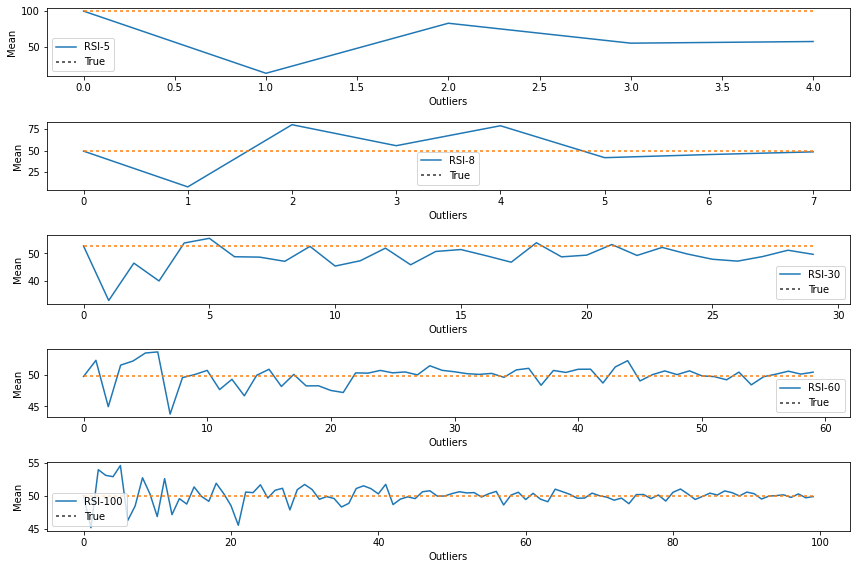

In [ ]:
plot_means(df=df_periods_info, periods=[5, 8, 30, 60, 100], y_names=['Mean', 'Mean-without-outliers'], prefix='RSI-')
plt.tight_layout()
plt.show()

Looking at the charts the answer becomes obvious; past a certain period gap we will not see real changes, even in the presence of high volatility. This means that when the RSI becomes large the movement is slower and slower.

There are not so many differences between the RSI of 30, 50 and 100 periods, this has to do with what was analyzed in the section of the SMA and it is key to understand it, because the RS formula (in the denominator) clearly indicates that these are SMAs, I must repeat this because it makes total sense with what we see in the highest periods of the RSI, when the denominator is very large the division will result in a final value of over-buy (since 100-100/{1+INF}=100), otherwise the denominator will tend to 1 + 0. ...=1... and the division will produce a value close to 100 so we will be in an over-sale (since 100-100/{1+0}=0).

## RSI reaction time and RSI speed without outliers

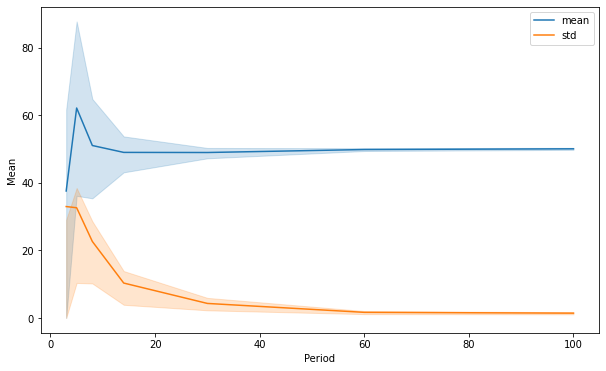

In [ ]:
plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_periods_info, x='Period', y='Mean', estimator="mean", label="mean")
sns.lineplot(data=df_periods_info, x='Period', y='Mean', estimator="std", label="std")
plt.show()

This is a relevant characteristic of the RSI to highlight, when it exceeds a certain period the values no longer produce relevant changes in the formula, even with the presence of outliers, in periods of time greater than 30 (approximately) this indicator absorbs the fluctuations of the values resulting in minimal or null movements. What we see after so many periods is the RSI returning to the mean of the price distribution and staying there almost unchanged, again when new values are incorporated the changes will not be easily detected.

**Conclusion**

The reaction quality of this indicator is not good, unless our strategy is based on detecting the most extreme changes(perhaps because the market studied has atypical excess returns) I recommend taking less than 30 periods(or an approximate), in which case we will look for abrupt changes and therefore it is advisable to have it in a maximum of 8 periods, with this we will better detect the most recent movements(another good measure used is 3 or 5 periods).
